תרגיל - ניתוח טקסט - סיווג סנטימנט

מטרת התרגיל היא לסווג סנטימנט שלילי/חיובי מתוך תגובות בדף הפייסבוק של הנשיא ריבלין.
ראשית, יש להיכנס לקישור הבא:
https://github.com/omilab/Neural-Sentiment-Analyzer-for-Modern-Hebrew
בקישור הנ״ל אפשר למצוא שני jupyter notebooks שבשלב זה לא רלוונטיים, אפשר להתעלם מהן. מה שכן נדרש שקריאת ההסבר בקובץ readme וקריאת המאמר עצמו. 
לאחר השלמת החלק התיאורטי, נדרש לכתוב מסווג פשוט המבוסס על TF-IDF אך לא רק ואפשר להשתמש ברעיונות נוספים כמו למשל POS. הרעיון, לממש מסווג פשוט ולא רשתות עמוקות, למשל אפשר להשתמש ב-Logistic Regression Classifier.


References
Introduction to Information Retrieval
Tf-idf weighting
How to Use Tfidftransformer & Tfidfvectorizer - A Short Tutorial
sklearn.feature_extraction.text.TfidfVectorizer — scikit-learn 0.24.2 documentation


In [2]:
import codecs
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from nltk.tokenize import TreebankWordTokenizer
import emoji
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer


In [4]:
def extract_emojis(text):
  return ''.join(c for c in text if c in emoji.UNICODE_EMOJI['en'])

def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)



In [5]:
def tfidf(data, ngrams=(1, 1)):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngrams)
    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

# Loading the data

In [ ]:
def load_data(filename):
    data = list(codecs.open(filename, 'r', 'utf-8').readlines())
    x, y = zip(*[d.strip().split('\t') for d in data])
    # Reducing any char-acter sequence of more than 3 consecutive repetitions to a respective 3-character sequence 
    # (e.g. “!!!!!!!!”turns to “!!!”)
    # x = [re.sub(r'((.)\2{3,})', r'\2\2\2', i) for i in x]
    x = np.asarray(list(x))
    y = np.array(y).astype(np.int)
    #y = to_categorical(y, 3)
    
    
    return x, y

In [41]:
x_token_train, y_token_train = load_data('data/token_train.tsv')
x_token_test, y_token_test = load_data('data/token_test.tsv')
x_morph_train, y_morph_train = load_data('data/morph_train.tsv')
x_morph_test, y_morph_test = load_data('data/morph_test.tsv')


In [162]:
# putting in dataframe

train_df = pd.DataFrame()
train_df["x_token_train"] = x_token_train
train_df["y_token_train"] = y_token_train
train_df["x_morph_train"] = x_morph_train
train_df["y_morph_train"] = y_morph_train

test_df = pd.DataFrame()
test_df["x_token_test"] = x_token_test
test_df["y_token_test"] = y_token_test
test_df["x_morph_test"] = x_morph_test
test_df["y_morph_test"] = y_morph_test


# EDA

## train_df

In [76]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10244 entries, 0 to 10243
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   x_token_train  10244 non-null  object
 1   y_token_train  10244 non-null  int32 
 2   x_morph_train  10244 non-null  object
 3   y_morph_train  10244 non-null  int32 
dtypes: int32(2), object(2)
memory usage: 240.2+ KB


In [77]:
train_df.describe()

,y_token_train,y_morph_train
count,10244.00000,10244.00000
mean,0.36392,0.36392
std,0.53823,0.53823
min,0.00000,0.00000
25%,0.00000,0.00000
50%,0.00000,0.00000
75%,1.00000,1.00000
max,2.00000,2.00000


<AxesSubplot:ylabel='y_token_train'>

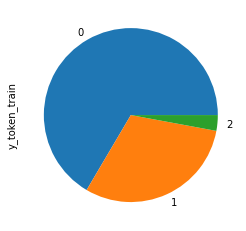

In [67]:
train_df.y_token_train.value_counts().plot(kind ='pie')

In [68]:
train_df.corr()

,y_token_train,y_morph_train
y_token_train,1.0,1.0
y_morph_train,1.0,1.0


In [70]:
train_df[train_df.y_token_train == 0][:5]

,x_token_train,y_token_train,x_morph_train,y_morph_train
0,ממש כואב ..... אני בוכה עם המשפחה שלא תדעו עוד...,0,ממש כואב ..... אני בכה את היא עם ה משפחה ש לא ...,0
1,איש יקר שלנו,0,איש יקר של אנחנו,0
2,כל הכבוד והמון בהצלחה,0,כל ה כבוד ו המון ב הצלחה,0
3,""" תל חי , רובי . בכל העצב הזה היית קרן אור של ...",0,""" תל חי , רובי . ב כל ה עצב ה זה היית קרן אור ...",0
4,נקי כפיים ובר לבב בהצלחה לך ולנו .,0,נקי כפיים ו בר לבב ב הצלחה ל אתה ו ל אנחנו .,0


In [71]:
train_df[train_df.y_token_train == 1][:5]

,x_token_train,y_token_train,x_morph_train,y_morph_train
9,אדוני הנשיא סליחה על הבוטות תפסיק לזיין את השכ...,1,אדוני ה נשיא סליחה על ה בוטות תפסיק לזיין את ה...,1
11,ואני עוד חשבתי שהגיע נשיא נורמלי,1,ו אני עוד חשבתי ש הגיע נשיא נורמלי,1
12,נשיא המדינה הלבן והמנותק חכם בדיבורים . הוא לא...,1,נשיא ה מדינה ה לבן ו ה מנותק חכם ב ה דיבורים ....,1
14,""" רובי ריבלין היקר !! אתה איש משפחה לא ???.. מ...",1,""" רובי ריבלין ה יקר !! אתה איש משפחה לא ???.. ...",1
18,עוד לא שבוע בתפקיד וכבר שכחת מאיפה באת ?,1,עוד לא שבוע ב ה תפקיד ו כבר שכחת מ איפה באת ?,1


In [72]:
train_df[train_df.y_token_train == 2][:5]

,x_token_train,y_token_train,x_morph_train,y_morph_train
53,חייבים לעשות סוג של חרם כשכתבים שונאי ישראל עו...,2,חייבים לעשות סוג של חרם כש כתבים שונאי ישראל ע...,2
78,אז אתה בא ? https://www.facebook.com/events/15...,2,אז אתה בא ? https://www.facebook.com/events/15...,2
82,""" גאי אתה טיפש מטופש ילד כאפות שלא חונך על ברכ...",2,""" גאי אתה טיפש מטופש ילד כאפות ש לא חונך על בר...",2
117,שמעון יפרח העלאתי בשבילך את דבריו של שמעון פרס...,2,ש מעון יפרח העלאתי בשביל אתה את דבריו של שמעון...,2
181,רובי ריבלין הנשיא העשירי תחזית שניתנה לפני הבח...,2,רובי ריבלין ה נשיא ה עשירי תחזית ש ניתנה לפני ...,2


The dataset contains:
1. **x_token_train** - collection of talkback as strings
2. **y_token_train** - Sentiment classification (target), (0 - Positive, 1 - Negative, 2 - Neutral)
3. **x_morph_train** - same as x_token_train, but seperated to prefix, nuclear word, suffix (morphologically rich language)
4. **y_morph_train** - same as y_token_train, since it is the same sentiment

morph examples:    

    לנשיאות
    ל ה נשיאות

    לה הצלחה
    ל היא הצלחה

In [ ]:
# dropping the duplicate y_morph_train column

In [163]:
train_df.drop('y_morph_train', axis='columns', inplace=True)
train_df.rename(columns={"y_token_train": "y_train"}, inplace=True)

In [164]:
train_df.head()

,x_token_train,y_train,x_morph_train
0,ממש כואב ..... אני בוכה עם המשפחה שלא תדעו עוד...,0,ממש כואב ..... אני בכה את היא עם ה משפחה ש לא ...
1,איש יקר שלנו,0,איש יקר של אנחנו
2,כל הכבוד והמון בהצלחה,0,כל ה כבוד ו המון ב הצלחה
3,""" תל חי , רובי . בכל העצב הזה היית קרן אור של ...",0,""" תל חי , רובי . ב כל ה עצב ה זה היית קרן אור ..."
4,נקי כפיים ובר לבב בהצלחה לך ולנו .,0,נקי כפיים ו בר לבב ב הצלחה ל אתה ו ל אנחנו .


In [84]:
# Cleaning methods:
def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

In [166]:
# adding a clean token column
train_df["clean_token"] = train_df.x_token_train.map(lambda x: remove_URL(x))
train_df["clean_token"] = train_df.x_token_train.map(lambda x: remove_html(x))
train_df["clean_token"] = train_df.x_token_train.map(lambda x: remove_emoji(x))
train_df["clean_token"] = train_df.x_token_train.map(lambda x: remove_punct(x))

In [88]:
train_df['target_label'] = train_df.y_token_train.replace({0: "Positive", 1: "Negative", 2: "Neutral"})

In [90]:
train_df[train_df.target_label == "Neutral"][:5]

,x_token_train,y_token_train,x_morph_train,clean_token,target_label
53,חייבים לעשות סוג של חרם כשכתבים שונאי ישראל עו...,2,חייבים לעשות סוג של חרם כש כתבים שונאי ישראל ע...,חייבים לעשות סוג של חרם כשכתבים שונאי ישראל עו...,Neutral
78,אז אתה בא ? https://www.facebook.com/events/15...,2,אז אתה בא ? https://www.facebook.com/events/15...,אז אתה בא httpswwwfacebookcomevents1539984016...,Neutral
82,""" גאי אתה טיפש מטופש ילד כאפות שלא חונך על ברכ...",2,""" גאי אתה טיפש מטופש ילד כאפות ש לא חונך על בר...",גאי אתה טיפש מטופש ילד כאפות שלא חונך על ברכי...,Neutral
117,שמעון יפרח העלאתי בשבילך את דבריו של שמעון פרס...,2,ש מעון יפרח העלאתי בשביל אתה את דבריו של שמעון...,שמעון יפרח העלאתי בשבילך את דבריו של שמעון פרס...,Neutral
181,רובי ריבלין הנשיא העשירי תחזית שניתנה לפני הבח...,2,רובי ריבלין ה נשיא ה עשירי תחזית ש ניתנה לפני ...,רובי ריבלין הנשיא העשירי תחזית שניתנה לפני הבח...,Neutral


In [92]:
train_df['target_label'] = train_df['target_label'].astype('category')

In [ ]:
# displaying a word cloud of the diffrent sentiment

In [99]:


stop_words =[]
with open('hebrew_stop_words.json', 'r') as f:
    stop_words = json.load(f)
    
# use get_display to convert the hebrew stop words, so the word cloud won't be reversed 
bd_hsw = get_display(" ".join(stop_words)).split(" ")

In [ ]:
from wordcloud import WordCloud

In [ ]:
# positive vs negative

In [103]:
positive_token_df = train_df[train_df.target_label=='Positive']

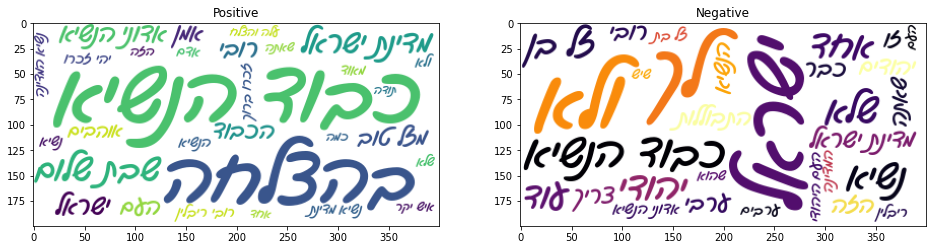

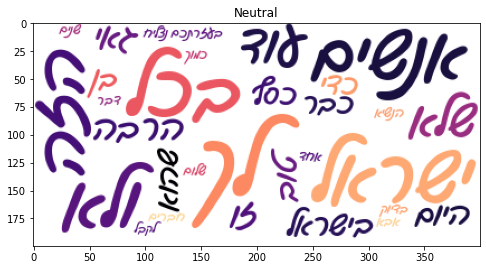

In [124]:
all_positive_wc = WordCloud(
    colormap='viridis',
    font_path='Fonts/GveretLevinAlefAlefAlef-Regular.ttf',
    background_color="white",
    stopwords=bd_hsw,
    max_words=30,
    max_font_size=80).generate(get_display(" ".join(train_df[train_df.target_label=='Positive'].clean_token)))

all_negative_wc = WordCloud(
    colormap='inferno',
    font_path='Fonts/GveretLevinAlefAlefAlef-Regular.ttf',
    background_color="white",
    stopwords=bd_hsw,
    max_words=30,
    max_font_size=80).generate(get_display(" ".join(train_df[train_df.target_label=='Negative'].clean_token)))

all_neutral_wc = WordCloud(
    colormap='magma',
    font_path='Fonts/GveretLevinAlefAlefAlef-Regular.ttf',
    background_color="white",
    stopwords=bd_hsw,
    max_words=30,
    max_font_size=80).generate(get_display(" ".join(train_df[train_df.target_label=='Neutral'].clean_token)))

plt.figure(1, figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title("Positive")
plt.imshow(all_positive_wc)

plt.subplot(1, 2, 2)
plt.title("Negative")
plt.imshow(all_negative_wc)

plt.figure(2, figsize=(8, 8))
plt.title("Neutral")
plt.imshow(all_neutral_wc)



# TF IDF & Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [ ]:
def tfidf(data, ngrams=(1, 1)):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngrams)
    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

## Token

In [168]:
# calculating the vectorizer - convert array of strings to frequency numeric value

print("Token tfidf_vectorizer")

train_tfidf, tfidf_vectorizer = tfidf(train_df.clean_token)

# Training the model

X = train_tfidf
y = train_df.y_train

X_train_tfidf, X_test, y_train_tfidf, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(class_weight="balanced")
model.fit(X_train_tfidf, y_train_tfidf)

y_pred = model.predict(X_test)

f1score = f1_score(y_test, y_pred, average='weighted')
print(f"Tfidf training Model Score: {f1score * 100} %")

# Testing the model
test_tfidf = tfidf_vectorizer.transform(test_df.x_token_test)
y_test_predict = model.predict(test_tfidf)

f1score = f1_score(y_test_predict, test_df.y_token_test, average='weighted')
print(f"Tfidf Test Model Score: {f1score * 100} %")

Token tfidf_vectorizer
Tfidf training Model Score: 87.10375140106963 %
Tfidf Test Model Score: 88.94299295639945 %


In [ ]:
## Morph

In [169]:
# calculating the vectorizer - convert array of strings to frequency numeric value

print("morph tfidf_vectorizer")

train_tfidf, tfidf_vectorizer = tfidf(train_df.x_morph_train)

# Training the model

X = train_tfidf
y = train_df.y_train

X_train_tfidf, X_test, y_train_tfidf, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(class_weight="balanced")
model.fit(X_train_tfidf, y_train_tfidf)

y_pred = model.predict(X_test)

f1score = f1_score(y_test, y_pred, average='weighted')
print(f"Tfidf training Model Score: {f1score * 100} %")

# Testing the model
test_tfidf = tfidf_vectorizer.transform(test_df.x_morph_test)
y_test_predict = model.predict(test_tfidf)

f1score = f1_score(y_test_predict, test_df.y_morph_test, average='weighted')
print(f"Tfidf Test Model Score: {f1score * 100} %")

morph tfidf_vectorizer
Tfidf training Model Score: 87.49622147649906 %
Tfidf Test Model Score: 88.13946565957372 %


Tfidf Model Score: 89.97976475379353 %


Test Model Score: 88.67423585408467 %


In [ ]:
# prepare the courpus

tokenizer = TreebankWordTokenizer()

train_df = pd.DataFrame()
train_df["text"] = x_token_train;

train_df["emoji"] = train_df.text.map(lambda x: set(extract_emojis(x)))

train_df["clean_text"] = train_df.text.map(lambda x: remove_URL(x))
train_df["clean_text"] = train_df.text.map(lambda x: remove_html(x))
train_df["clean_text"] = train_df.text.map(lambda x: remove_emoji(x))
train_df["clean_text"] = train_df.text.map(lambda x: remove_punct(x))

train_df["clean_tokens"] = train_df.clean_text.map(tokenizer.tokenize)

train_df["target"] = y_token_train


In [ ]:
Bag of words

In [ ]:
train_df.head()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


def count_vect(data, ngrams=(1, 1)):
    count_vectorizer = CountVectorizer(ngram_range=ngrams)
    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

In [ ]:
train_counts, count_vectorizer = count_vect(train_df["clean_text"])
test_counts = count_vectorizer.transform(x_token_test)

In [ ]:
type(train_counts)

In [ ]:
train_counts.todense().shape

In [ ]:
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(text)

In [ ]:
print(train_counts.todense()[0][0:].sum())

In [ ]:
train_counts, count_vectorizer = count_vect(train_df.clean_text, ngrams=(1, 2))
test_counts = count_vectorizer.transform(x_token_test)

In [ ]:
print(train_counts.todense()[0][0:].sum())

In [ ]:
# TF IDF
from sklearn.feature_extraction.text import TfidfVectorizer


def tfidf(data, ngrams=(1, 1)):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngrams)
    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer


train_tfidf, tfidf_vectorizer = tfidf(train_df.clean_text)
test_tfidf = tfidf_vectorizer.transform(x_token_test)

In [ ]:
[x for x in train_tfidf.todense()[0][0:].tolist()[0] if x != 0]

In [ ]:
print(train_tfidf.todense()[0][0:].sum())

In [ ]:
rain_tfidf, tfidf_vectorizer = tfidf(train_df.clean_text, ngrams=(1, 2))
test_tfidf = tfidf_vectorizer.transform(x_token_test)

In [ ]:
print(train_tfidf.todense()[0][0:].sum())

In [ ]:
X_counts = train_counts
X_tfidf = train_tfidf
y = y_token_train

In [ ]:
type(y)

In [ ]:
# TF IDF

In [ ]:
test_df = pd.DataFrame()
test_df["text"] = x_token_test;


In [130]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


def tfidf(data, ngrams=(1, 1)):
    tfidf_vectorizer = TfidfVectorizer(ngram_range=ngrams)
    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer


train_tfidf, tfidf_vectorizer = tfidf(train_df.clean_text)
# test_tfidf = tfidf_vectorizer.transform(test_df["text"])

AttributeError: 'DataFrame' object has no attribute 'clean_text'

In [ ]:
type(train_df.clean_text)

In [ ]:
train_tfidf, tfidf_vectorizer = tfidf(train_df["clean_text"])

In [ ]:
X = train_tfidf
y = y_token_train

X_train_tfidf, X_test, y_train_tfidf, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2020
)

In [ ]:
model = LogisticRegression(class_weight="balanced")
model.fit(X_train_tfidf, y_train_tfidf)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
X_test

In [ ]:
y_pred

In [ ]:
(1 - abs((y_test - y_pred).sum() / len(y_pred))) * 100

In [ ]:
f1score = f1_score(y_test, y_pred, average='weighted')
print(f"Tfidf Model Score: {f1score * 100} %")

In [ ]:
test_dfidf = 